In [187]:
import cv2
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from com import *

In [188]:
def mi_quick(a,b,d,bn=32):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

def MI(A, B, dms, n_state):
    mi_AA = [mi_quick(A,A,d,n_state) for d in dms]
    mi_AB = [mi_quick(A,B,d,n_state) for d in dms]
    mi_BB = [mi_quick(B,B,d,n_state) for d in dms]

    mi_all = [mi_AA, mi_AB, mi_BB]
    
    return mi_all

# Robot Fish

In [373]:
path = r"/media/isis0517/QVO2/0610/09"
#imgspath = "/home/isis0517/Documents/data/imgs"

def getkey(x):
    temp = x.split("_")
    s = int(temp[-1].split(".")[0])
    return (temp[0], s)

flist = os.listdir(path)
flist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(flist))

18000


## generate the background

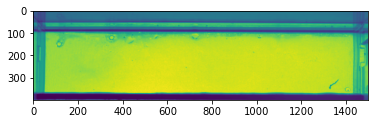

In [374]:
tnum = np.random.randint(15000, size=len(flist)//10)

a = np.load(os.path.join(path, flist[0]))
background = np.zeros(a.shape)

for s in tnum:
    a = np.load(os.path.join(path, flist[s]))
    a = cv2.blur(a, ksize=(3, 3))
    background += a
background = background/len(tnum)
background = background.astype('uint8')

plt.imshow(background)

## pick the range where the video is played

In [ ]:
poses = []
y = []
start_frame, end_frame = 0, 0
for s, filename in enumerate(tqdm(flist)):
    load_img = np.load(os.path.join(path, filename))
    if np.sum(load_img)>40000000:
        img = load_img
        img = cv2.absdiff(img, background)
        img = img>90
        img = (img*255).astype('uint8')
        pos = get_pos(img)
        poses.append(pos)
        y.append(pos[1])
        if start_frame==0:
            start_frame = s
        elif start_frame != 0:
            end_frame = s
    elif start_frame != 0:
        break

  0%|          | 0/18000 [00:00<?, ?it/s]

## load the trajectory 

In [ ]:
print(end_frame-start_frame, start_frame, end_frame)
input_poses = np.load("/media/isis0517/UBUNTU 20_0/202106_exp1/rob_poses.npy")
input_y = []
for pos in input_poses:
    input_y.append(pos[1])
print(len(input_poses))

## cal the MI

In [ ]:
print(max(y), min(y))

y1 = (np.array(y)-min(y))/(max(y)-min(y))
y2 = (np.array(input_y)-min(input_y))/(max(input_y)-min(input_y))

In [ ]:

plt.figure(figsize=(15,4))
plt.plot(y1, label='real', c='red')
plt.plot(y2, label='robot')
plt.title('Position (pixel)')
plt.xlabel('Frame')
plt.ylabel('Pixel')
plt.legend()
plt.show()

In [ ]:
NUMofStates = 16
dms = range(-100,100,1)

mi_close = MI(y1, y2[:len(y1)], dms, NUMofStates)
plt.figure()
#plt.plot(dms,mi_close[0],label='Auto_A',color='black')
plt.plot(dms,mi_close[1],label='Mi_AB',color='green')
#plt.plot(dms,mi_close[2],'--',label='Auto_B',color='red')
#plt.scatter(dms[np.argmax(mi_close[1])], np.max(mi_close[1]), color='r')
#plt.axvline(dms[np.argmax(mi_close[1])], color='r', linestyle='--')
plt.ylabel('mutual information (bits)')
plt.xlabel('time delay (steps)')
plt.title('TDMI')
plt.legend()   
plt.ylim([0,0.3])
plt.savefig(f"{path.split('/')[-2]}_{path.split('/')[-1]}.png")
plt.show()
print(f"{path.split('/')[-1]}.png")
print(np.argmax(mi_close[1]))

# origin

In [358]:
path = r"/media/isis0517/QVO2/0610/07"
#imgspath = "/home/isis0517/Documents/data/imgs"

def getkey(x):
    temp = x.split("_")
    s = int(temp[-1].split(".")[0])
    return (temp[0], s)

flist = os.listdir(path)
flist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(flist))

18000


In [359]:
%%script false --no-raise-error
img = np.load(os.path.join(path, flist[0]))

input_vidoe = cv2.VideoCapture("/media/isis0517/QVO2/0507/0419FaMb1(top)_red.avi")
video = cv2.VideoWriter("dot_vidoe.avi", cv2.CAP_FFMPEG, cv2.VideoWriter_fourcc(*"XVID"), 30, (img.shape[1], img.shape[0]+400), False)

input_img = np.zeros((400, img.shape[1]), dtype='uint8')
ret = False

for s, filename in enumerate(tqdm(flist)):
    load_img = np.load(os.path.join(path, filename))
    if np.sum(load_img)>90000000 or ret:
        ret, frame = input_vidoe.read()
        if not ret:
            frame = np.zeros((400, img.shape[1], 3), dtype='uint8')
        temp = frame[:400,...]
        temp = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)
        temp = np.where(temp>10, 200, 0).astype('uint8')
        input_img = cv2.resize(temp, (input_img.shape[1], input_img.shape[0]))
        
    #print(input_img.shape, load_img.shape)
    img = np.concatenate((input_img, load_img), axis = 0)
    img = cv2.putText(img, f"{s}", (1700,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255), 1)
    video.write(img)
video.release()

## generate the background

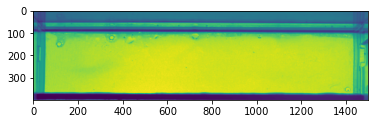

In [360]:
tnum = np.random.randint(15000, size=len(flist)//10)

a = np.load(os.path.join(path, flist[0]))
background = np.zeros(a.shape)

for s in tnum:
    a = np.load(os.path.join(path, flist[s]))
    a = cv2.blur(a, ksize=(3, 3))
    background += a
background = background/len(tnum)
background = background.astype('uint8')

plt.imshow(background)

In [361]:
poses = []
y = []
start_frame, end_frame = 0, 0
for s, filename in enumerate(tqdm(flist)):
    load_img = np.load(os.path.join(path, filename))
    if np.sum(load_img)>40000000:
        img = load_img
        img = cv2.absdiff(img, background)
        img = img>90
        img = (img*255).astype('uint8')
        pos = get_pos(img)
        poses.append(pos)
        y.append(pos[1])
        if start_frame==0:
            start_frame = s
        elif start_frame != 0:
            end_frame = s
    elif start_frame != 0:
        break

  0%|          | 0/18000 [00:00<?, ?it/s]

## load the trejactory

In [362]:
print(end_frame-start_frame, start_frame, end_frame)
input_poses = np.load("/media/isis0517/UBUNTU 20_0/202106_exp1/ori_poses.npy")

input_y = []

for pos in input_poses:
    input_y.append(pos[1])
    
xval = np.arange(len(y))*(1/30)
x = np.arange(len(input_poses))*(1/20)
input_y = np.interp(xval, x, input_y)

print(xval[:10])
    
print(len(input_y))

14999 182 15181
[0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3       ]
15000


In [363]:
   
y1 = (np.array(y)-min(y))/(max(y)-min(y))
y2 = (np.array(input_y)-min(input_y))/(max(input_y)-min(input_y))

#     img = img.astype('uint8')
#     pos = get_pos(img)


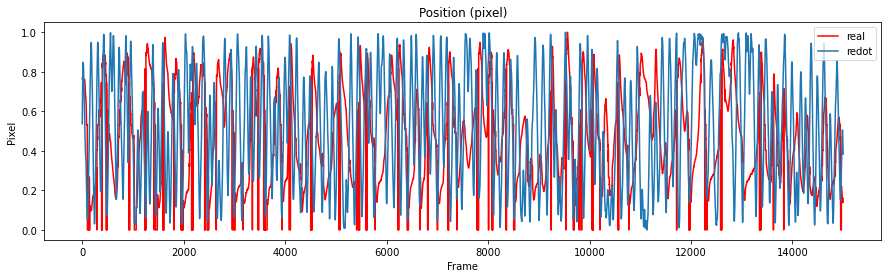

In [364]:

plt.figure(figsize=(15,4))
plt.plot(y1, label='real', c='red')
plt.plot(y2, label='redot')
plt.title('Position (pixel)')
plt.xlabel('Frame')
plt.ylabel('Pixel')
plt.legend()
plt.show()

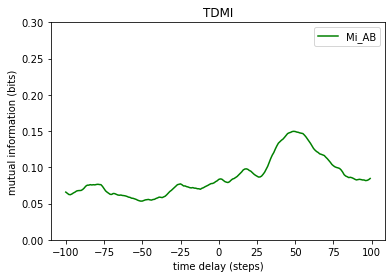

149


In [365]:
NUMofStates = 16
dms = range(-100,100,1)

mi_close = MI(y1, y2[:len(y1)], dms, NUMofStates)
plt.figure()
#plt.plot(dms,mi_close[0],label='Auto_A',color='black')
plt.plot(dms,mi_close[1],label='Mi_AB',color='green')
#plt.plot(dms,mi_close[2],'--',label='Auto_B',color='red')
#plt.scatter(dms[np.argmax(mi_close[1])], np.max(mi_close[1]), color='r')
#plt.axvline(dms[np.argmax(mi_close[1])], color='r', linestyle='--')
plt.ylabel('mutual information (bits)')
plt.xlabel('time delay (steps)')
plt.title('TDMI')
plt.legend()   
plt.ylim([0,0.3])
plt.savefig(f"{path.split('/')[-2]}_{path.split('/')[-1]}_ori.png")
plt.show()
print(np.argmax(mi_close[1]))

# The free moving data

In [349]:
path = r"/media/isis0517/QVO2/0507/database"
#imgspath = "/home/isis0517/Documents/data/imgs"

def getkey(x):
    temp = x.split("_")
    s = int(temp[-1].split(".")[0])
    return (temp[0], s)

flist = os.listdir(path)
flist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(flist))

10800


## save as video

In [49]:
img = np.load(os.path.join(path, flist[0]))

input_vidoe = cv2.VideoCapture("/media/isis0517/QVO2/0507/database.avi")
video = cv2.VideoWriter("data_vidoe.avi", cv2.CAP_FFMPEG, cv2.VideoWriter_fourcc(*"MJPG"), 20, (img.shape[1], img.shape[0]+400), False)
for s in range(30):
    ret, frame = input_vidoe.read()

input_img = np.zeros((400, img.shape[1]), dtype='uint8')
ret = False

for s, filename in enumerate(tqdm(flist)):
    load_img = np.load(os.path.join(path, filename))
    if np.sum(load_img)>80000000 or ret:
        ret, frame = input_vidoe.read()
        if not ret:
            frame = np.zeros((400, img.shape[1], 3), dtype='uint8')
        temp = frame[:400,...]
        temp = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)
        input_img = cv2.resize(temp, (input_img.shape[1], input_img.shape[0]))
        
    #print(input_img.shape, load_img.shape)
    img = np.concatenate((input_img, load_img), axis = 0)
    img = cv2.putText(img, f"{s}", (1700,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255), 1)
    video.write(img)
input_vidoe.release()
video.release()

  0%|          | 0/10800 [00:00<?, ?it/s]

In [22]:
start_frame, end_frame = 0, 0
for s, filename in enumerate(tqdm(flist)):
    load_img = np.load(os.path.join(path, filename))
    if np.sum(load_img)>80000000:
        if start_frame==0:
            start_frame = s
        elif start_frame != 0:
            end_frame = s

  0%|          | 0/10800 [00:00<?, ?it/s]

In [23]:
print(end_frame-start_frame)
input_poses = np.load("/media/isis0517/QVO2/0507/database_poses.npy")
input_y = []
for pos in input_poses:
    input_y.append(pos[1])
print(len(input_poses))

9999
10000


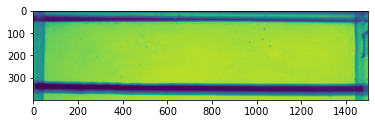

In [24]:
tnum = np.random.randint(start_frame, end_frame, size=len(input_poses)//10)

a = np.load(os.path.join(path, flist[0]))
background = np.zeros(a.shape)

for s in tnum:
    a = np.load(os.path.join(path, flist[s]))
    a = cv2.blur(a, ksize=(3, 3))
    background += a
background = background/len(tnum)
background = background.astype('uint8')

plt.imshow(background)

In [25]:
poses = []
y = []
for s in tqdm(range(start_frame, end_frame)):
    img = np.load(os.path.join(path, flist[s]))
    img = cv2.absdiff(img, background)
    img = img>90
    img = (img*255).astype('uint8')
    pos = get_pos(img)
    poses.append(pos)
    y.append(pos[1])

    
y1 = (np.array(y)-min(y))/(max(y)-min(y))
y2 = (np.array(input_y)-min(input_y))/(max(input_y)-min(input_y))

#     img = img.astype('uint8')
#     pos = get_pos(img)

  0%|          | 0/9999 [00:00<?, ?it/s]

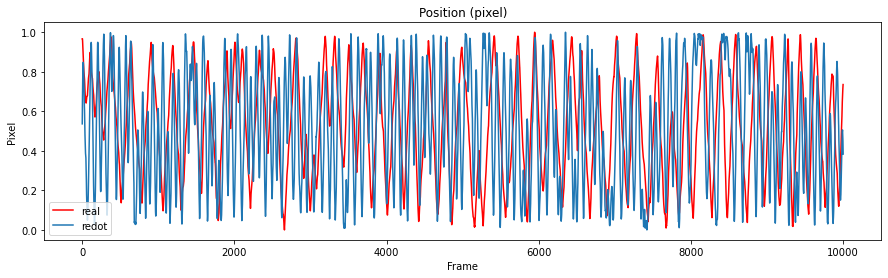

In [26]:

plt.figure(figsize=(15,4))
plt.plot(y1, label='real', c='red')
plt.plot(y2, label='redot')
plt.title('Position (pixel)')
plt.xlabel('Frame')
plt.ylabel('Pixel')
plt.legend()
plt.show()

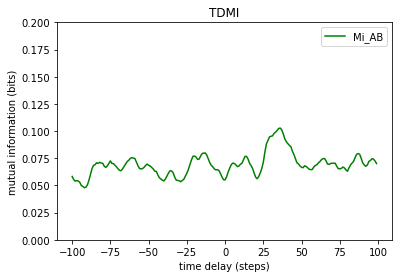

136


In [27]:
NUMofStates = 16
dms = range(-100,100,1)

mi_close = MI(y1, y2[:-1], dms, NUMofStates)
plt.figure()
#plt.plot(dms,mi_close[0],label='Auto_A',color='black')
plt.plot(dms,mi_close[1],label='Mi_AB',color='green')
#plt.plot(dms,mi_close[2],'--',label='Auto_B',color='red')
#plt.scatter(dms[np.argmax(mi_close[1])], np.max(mi_close[1]), color='r')
#plt.axvline(dms[np.argmax(mi_close[1])], color='r', linestyle='--')
plt.ylabel('mutual information (bits)')
plt.xlabel('time delay (steps)')
plt.title('TDMI')
plt.legend()   
plt.ylim([0,0.2])
plt.show()
print(np.argmax(mi_close[1]))